In [4]:
%pip install imbalanced-learn

  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imbalanced-learn][imbalanced-learn]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os, logging, random, gc, time, warnings
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger


from tqdm.auto import tqdm

from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

# Check the TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.19.0
Num GPUs Available: 0


In [14]:
class CFG:
    seed = 42
    debug = False
    print_freq = 100
    num_workers = 1

    # Project root
    PROJECT_ROOT_DIR_root = Path.cwd().parents[2]

    PROJECT_ROOT_DIR = PROJECT_ROOT_DIR_root / 'notebooks/notebooks_wk'
    
    OUTPUT_DIR = PROJECT_ROOT_DIR / 'data/working/'
    SPECTROGRAMS_DIR = OUTPUT_DIR / 'spectograms'
    
    train_data_dir = PROJECT_ROOT_DIR / 'data/raw/train_audio'
    train_csv = PROJECT_ROOT_DIR / 'data/raw/train.csv'
    taxonomy_csv = PROJECT_ROOT_DIR / 'data/raw/taxonomy.csv'
    working_df_path = PROJECT_ROOT_DIR / 'data//work_df_w_split_info.csv'

    # Define subfolders in OUTPUT_DIR
    MODELS_DIR = OUTPUT_DIR / 'models'
    PLOTS_DIR = OUTPUT_DIR / 'plots'
    RESULTS_CSV_DIR = OUTPUT_DIR / 'result_csvs'

    # Create directories if they don't exist
    os.makedirs(MODELS_DIR, exist_ok=True)
    os.makedirs(PLOTS_DIR, exist_ok=True)
    os.makedirs(RESULTS_CSV_DIR, exist_ok=True)

    # Parametric input dim (32, 64, or 256)
    # This would be used to also control the input path and shape (see below)
    input_dim = 32 # Default to 32
    
    # Derived paths and shapes
    @property
    def spectrogram_npy(self):
        return self.SPECTROGRAMS_DIR / f'birdclef2025_melspec_5sec_{self.input_dim}_{self.input_dim}.npy'
    
    @property  # Add this to make it dynamic
    def TARGET_SHAPE(self):
        return (self.input_dim, self.input_dim)
    
    in_channels = 1  # Single channel
    LOAD_DATA = True # Load data from precomputed spectrograms
    num_classes = 4  # 4 high-level classes

    epochs = 10
    batch_size = 128
    
    n_fold = 4
    selected_folds = [0,1,2,3]  # Use all folds by default

    lr = 5e-4 
    weight_decay = 1e-5
    min_lr = 1e-6
    
    use_augmentation = False  # Toggle augmentation on/off
    use_oversampling = False # Toggle oversampling on/off
    use_class_weights = False # Toggle class weights on/off

    oversample_option = 1 # set to 1 for repetitive oversampling // 2 is weighted sampling

    # Augmentation params
    aug_prob = 0.5 if use_augmentation else 0.0  # Probability of applying any augmentation
    mixup_alpha = 0.2 if use_augmentation else 0.0  # MixUp alpha (beta distribution)
    noise_std = 0.05  # Std dev for Gaussian noise
    max_time_shift = 0.2  # Fraction of time axis to shift (e.g., 20%)
    max_freq_shift = 0.2  # Fraction of freq axis to shift
    max_mask_time = 0.1  # Fraction of time axis to mask
    max_mask_freq = 0.1  # Fraction of freq axis to mask

    # Oversampling params: dict of {class_index: factor} to multiply minority samples
    # e.g., Aim to balance towards Aves (~5530 samples); set factor=0 for majority
    oversampling_factors = {0: 40,  # Amphibia (117 -> ~4680)
                            1: 0,   # Aves (majority, no oversampling)    
                            2: 150, # Insecta (31 -> ~4650)
                            3: 150, # Mammalia (35 -> ~5250)
                            }   
    
    # Derived model save name
    @property
    def model_save_name(self):
        suffix = ""
        if self.use_augmentation:
            suffix += "_aug"
        if self.use_oversampling:
            suffix += "_os"
        if self.use_class_weights:
            suffix += "_cw"
        return f"base_model_{str(self.input_dim)}{suffix}.keras"

    def update_debug_settings(self):
        # Only run 1 fold and 6 epochs in debug mode, we will use this as a quick test
        if self.debug:
            self.epochs = 3
            self.selected_folds = [0]

cfg = CFG()

In [15]:
def add_noise(spec, std):
    noise = tf.random.normal(shape=tf.shape(spec), mean=0.0, stddev=std, dtype=tf.float32)
    return spec + noise

def time_shift(spec, shift_frac):
    shift = int(shift_frac * spec.shape[1])  # Time axis is dim 1
    return tf.roll(spec, shift=shift, axis=1)

def freq_shift(spec, shift_frac):
    shift = int(shift_frac * spec.shape[0])  # Freq axis is dim 0
    return tf.roll(spec, shift=shift, axis=0)

def mask_time(spec, mask_frac):
    mask_len = int(mask_frac * spec.shape[1])
    if mask_len == 0:
        return spec
    start = tf.random.uniform(shape=[], minval=0, maxval=spec.shape[1] - mask_len, dtype=tf.int32)
    mask = tf.zeros((spec.shape[0], mask_len, spec.shape[2]), dtype=spec.dtype)
    spec = tf.concat([spec[:, :start, :], mask, spec[:, start + mask_len:, :]], axis=1)
    return spec

def mask_freq(spec, mask_frac):
    mask_len = int(mask_frac * spec.shape[0])
    if mask_len == 0:
        return spec
    start = tf.random.uniform(shape=[], minval=0, maxval=spec.shape[0] - mask_len, dtype=tf.int32)
    mask = tf.zeros((mask_len, spec.shape[1], spec.shape[2]), dtype=spec.dtype)
    spec = tf.concat([spec[:start, :, :], mask, spec[start + mask_len:, :, :]], axis=0)
    return spec

def mixup(spec1, target1, spec2, target2, alpha):
    lam = np.random.beta(alpha, alpha)
    spec = lam * spec1 + (1 - lam) * spec2
    target = lam * target1 + (1 - lam) * target2
    return spec, target



In [16]:
def data_generator(df, cfg, spectrograms, is_train=True, yield_weight=True):
    rows = df.to_dict('records')

    if cfg.use_oversampling and is_train:
        oversampled_rows = []
        for cls, factor in cfg.oversampling_factors.items():
            class_rows = [r for r in rows if r['y_species_encoded'] == cls]
            multiplier = max(1, factor)
            oversampled_rows.extend(class_rows * multiplier)
        random.shuffle(oversampled_rows)
        rows = oversampled_rows

    for row in rows:
        samplename = row['samplename']
        spec = spectrograms.get(samplename, np.zeros((*cfg.TARGET_SHAPE, cfg.in_channels), dtype=np.float32))
        spec = np.expand_dims(spec, axis=-1)
        spec = tf.convert_to_tensor(spec, dtype=tf.float32)

        target = to_categorical(row['y_species_encoded'], num_classes=cfg.num_classes)

        if is_train and cfg.use_augmentation and np.random.rand() < cfg.aug_prob:
            if np.random.rand() < 0.5:
                spec = add_noise(spec, cfg.noise_std)
            if np.random.rand() < 0.5:
                spec = time_shift(spec, cfg.max_time_shift)
            if np.random.rand() < 0.5:
                spec = freq_shift(spec, cfg.max_freq_shift)
            if np.random.rand() < 0.5:
                spec = mask_time(spec, cfg.max_mask_time)
            if np.random.rand() < 0.5:
                spec = mask_freq(spec, cfg.max_mask_freq)

            if cfg.mixup_alpha > 0 and np.random.rand() < 0.5:
                other_row = random.choice(rows)
                other_spec = spectrograms.get(other_row['samplename'], np.zeros_like(spec.numpy()))
                other_spec = tf.convert_to_tensor(np.expand_dims(other_spec, axis=-1), dtype=tf.float32)
                other_target = to_categorical(other_row['y_species_encoded'], num_classes=cfg.num_classes)
                spec, target = mixup(spec, target, other_spec, other_target, cfg.mixup_alpha)

        spec = spec.numpy()  # back to numpy for Dataset generator
        if yield_weight:
            sample_weight = class_weights[row['y_species_encoded']]
            yield spec, target, sample_weight
        else:
            yield spec, target


In [17]:
# augmentatin using zoom and contrast
data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [18]:
def create_dataset(df, cfg, spectrograms, is_train=True, yield_weight=True):
    output_signature = (
        tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
        tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32),
    )
    if yield_weight:
        output_signature = (
            output_signature[0],
            output_signature[1],
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )

    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(df, cfg, spectrograms, is_train=is_train, yield_weight=yield_weight),
        output_signature=output_signature
    )

    if is_train:
        dataset = dataset.shuffle(2048)

        def augment_fn(spec, label, weight=None):
            # using the augmentation layer here
            spec = data_augmentation_layer(spec)
            return (spec, label, weight) if yield_weight else (spec, label)

        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [19]:
print("\nLoading combined train data...")
full_df = pd.read_csv(cfg.working_df_path)

# Combine train and val as "combined train"
combined_train_val_df = full_df[full_df['split'].isin(['train', 'val'])].reset_index(drop=True)

combined_train_val_df.head()


Loading combined train data...


,primary_label,rating,filename,target,filepath,samplename,class,y_species_encoded,split
0,1139490,0.0,1139490/CSA36389.ogg,0,./data/raw/train_audio/1139490/CSA36389.ogg,1139490-CSA36389,Insecta,2,train
1,1192948,0.0,1192948/CSA36358.ogg,1,./data/raw/train_audio/1192948/CSA36358.ogg,1192948-CSA36358,Insecta,2,train
2,1192948,0.0,1192948/CSA36366.ogg,1,./data/raw/train_audio/1192948/CSA36366.ogg,1192948-CSA36366,Insecta,2,train
3,1192948,0.0,1192948/CSA36373.ogg,1,./data/raw/train_audio/1192948/CSA36373.ogg,1192948-CSA36373,Insecta,2,val
4,1194042,0.0,1194042/CSA18783.ogg,2,./data/raw/train_audio/1194042/CSA18783.ogg,1194042-CSA18783,Insecta,2,val


In [20]:
# Load pre-computed mel spectrograms
spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
print(f"Loaded {len(spectrograms)} pre-computed mel spectrograms")
print(f"Example spectrogram shape: {spectrograms['1139490-CSA36389'].shape}")

# This is a dict, the samplename '1139490-CSA36389' is the key
spectrograms['1139490-CSA36389']

Loaded 28564 pre-computed mel spectrograms
Example spectrogram shape: (32, 32)


array([[0.60927516, 0.82787275, 0.8543863 , ..., 0.5926887 , 0.8844918 ,
        0.7155297 ],
       [0.619291  , 0.89863867, 0.7358351 , ..., 0.60509133, 0.86708546,
        0.6459563 ],
       [0.53857917, 0.6364324 , 0.7601948 , ..., 0.54124737, 0.7848017 ,
        0.66509414],
       ...,
       [0.2903521 , 0.21302953, 0.23228   , ..., 0.24894655, 0.1931243 ,
        0.2143865 ],
       [0.2715999 , 0.22699611, 0.22744066, ..., 0.21395011, 0.23434846,
        0.22203825],
       [0.23533896, 0.2204537 , 0.20143878, ..., 0.23799029, 0.22495545,
        0.21065843]], dtype=float32)

In [21]:
# Custom class weights based on the distribution in the combined train/val set
@tf.keras.utils.register_keras_serializable()
class AddClsToken(tf.keras.layers.Layer):
    def __init__(self, projection_dim, **kwargs):
        super(AddClsToken, self).__init__(**kwargs)
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.cls_token = self.add_weight(
            shape=(1, 1, self.projection_dim),
            initializer="zeros",
            trainable=True,
            name="cls_token"
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls = tf.tile(self.cls_token, [batch_size, 1, 1])
        return tf.concat([cls, inputs], axis=1)

    def get_config(self):
        config = super(AddClsToken, self).get_config()
        config.update({"projection_dim": self.projection_dim})
        return config

@tf.keras.utils.register_keras_serializable()
def macro_f1_fn(y_true, y_pred):
    """Pure TensorFlow macro F1 implementation"""
    y_true_labels = tf.argmax(y_true, axis=-1)
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    
    num_classes = tf.shape(y_true)[-1]
    f1_scores = []
    
    for class_id in range(4):  # Use your num_classes=4
        true_class = tf.equal(y_true_labels, class_id)
        pred_class = tf.equal(y_pred_labels, class_id)
        
        tp = tf.reduce_sum(tf.cast(tf.logical_and(true_class, pred_class), tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(true_class), pred_class), tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(true_class, tf.logical_not(pred_class)), tf.float32))
        
        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        
        f1_scores.append(f1)
    
    return tf.reduce_mean(tf.stack(f1_scores))

In [22]:
def get_vit_model(cfg):
    input_shape = (*cfg.TARGET_SHAPE, cfg.in_channels)  # (32,32,1) or similar
    inputs = layers.Input(shape=input_shape)

    # Patch + Embed (conv stem)
    patch_size = 4
    projection_dim = 128  # Increased
    num_patches = (cfg.input_dim // patch_size) ** 2  # 64 for input_dim=32, etc.

    x = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    x = layers.Reshape((num_patches, projection_dim))(x)

    # Add class token using the custom layer
    x = AddClsToken(projection_dim=projection_dim)(x)

    # Positional embeddings (for num_patches + 1 positions)
    positions = tf.range(start=0, limit=num_patches + 1, delta=1)
    pos_embed = layers.Embedding(input_dim=num_patches + 1, output_dim=projection_dim)(positions)
    x = x + pos_embed

    # Transformer encoders
    num_blocks = 6  # Increased
    num_heads = 8   # Increased
    mlp_dim = 256   # Increased

    for _ in range(num_blocks):
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim // num_heads, dropout=0.2)(y, y)
        x = layers.Add()([x, y])

        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(mlp_dim, activation='gelu')(y)
        y = layers.Dropout(0.2)(y)
        y = layers.Dense(projection_dim)(y)
        x = layers.Add()([x, y])

    # Head: Use class token instead of GAP
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = x[:, 0, :]  # Extract cls_token
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(cfg.num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)

    return model

# # Chekc the model struture
# test_model = get_vit_model(cfg)

# test_model.compile(
#     optimizer = tf.keras.optimizers.AdamW(cfg.lr, weight_decay=cfg.weight_decay),
#     loss      = tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0, alpha=0.25),
#     metrics   = [
#         "accuracy",
#         tf.keras.metrics.AUC(name="auc"),
#         tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
#         macro_f1_fn,                    # your custom metric
#     ],
# )

# # Get the model summary
# test_model.summary()

# # Clean up
# del test_model
# gc.collect()

In [23]:
# Sanity check: Print class counts across full dataset
class_counts = combined_train_val_df['y_species_encoded'].value_counts().sort_index()
print("Full dataset class distribution (0: Amphibia, 1: Aves, 2: Insecta, 3: Mammalia):")
print(class_counts)
print(f"Imbalance ratio: Aves / Total = {class_counts[1] / class_counts.sum():.2%}")

# Create class mapping dictionary
class_mapping_dict = {
    0: 'Amphibia',
    1: 'Aves',
    2: 'Insecta',
    3: 'Mammalia'
}

# Sanity check 2: Inspect a batch from the generator
gen = data_generator(combined_train_val_df[combined_train_val_df['split'] == 'train'], cfg, spectrograms, is_train=True, yield_weight=False)
batch_specs, batch_labels = next(gen)  # Get one item (since generator is per-sample)
print("\nExample batch label (one-hot):", batch_labels)
print("Class order matches Dense layer: [Amphibia, Aves, Insecta, Mammalia]")

# Create class weights for imbalanced dataset
classes = np.unique(combined_train_val_df['y_species_encoded'])
labels = combined_train_val_df['y_species_encoded'].values

if cfg.use_class_weights:
    print("\nComputing class weights...")
    class_weights = compute_class_weight('balanced', classes=classes, y=labels)
    class_weights_dict = dict(zip(classes, class_weights))
    print("Computed class weights:", class_weights_dict)
else:
    print("\nUsing uniform class weights")
    class_weights_dict = {i: 1.0 for i in range(cfg.num_classes)}  # Uniform weights when toggled off
    


Full dataset class distribution (0: Amphibia, 1: Aves, 2: Insecta, 3: Mammalia):
y_species_encoded
0      466
1    22118
2      124
3      143
Name: count, dtype: int64
Imbalance ratio: Aves / Total = 96.79%

Example batch label (one-hot): [0. 0. 1. 0.]
Class order matches Dense layer: [Amphibia, Aves, Insecta, Mammalia]

Using uniform class weights


In [24]:
def make_ds(df, is_train, with_weight=True):
    sig = (
        tf.TensorSpec((*cfg.TARGET_SHAPE, cfg.in_channels), tf.float32),
        tf.TensorSpec((cfg.num_classes,), tf.float32),
    )
    if with_weight:
        sig += (tf.TensorSpec((), tf.float32),)

    # per-class data generator
    def get_class_generator(sub_df):
        def gen():
            for _, row in sub_df.iterrows():
                spec = spectrograms.get(row['samplename'], np.zeros((*cfg.TARGET_SHAPE, cfg.in_channels)))
                label = tf.one_hot(row['y_species_encoded'], cfg.num_classes)
                weight = 1.0
                yield (spec, label, weight) if with_weight else (spec, label)
        return gen

    if is_train and cfg.oversample_option in [1, 2]:
        class_counts = df['y_species_encoded'].value_counts()
        max_count = class_counts.max()
        datasets = []
        sampling_probs = []

        for class_label in sorted(class_counts.index):
            class_df = df[df['y_species_encoded'] == class_label]

            # Option 1: Repeat each class to match max_count (largest class, Aves)
            if cfg.oversample_option == 1:
                repeat_factor = int(np.ceil(max_count / len(class_df)))
                class_df = pd.concat([class_df] * repeat_factor, ignore_index=True)

            # Make a dataset from generator
            gen = get_class_generator(class_df)
            ds = tf.data.Dataset.from_generator(gen, output_signature=sig).repeat()

            datasets.append(ds)

            # Option 2: Calculate sampling probabilities inversely proportional to class frequency (Inverse frequency sampling)
            if cfg.oversample_option == 2:
                sampling_probs.append(1.0 / class_counts[class_label])

        if cfg.oversample_option == 2:
            # Normalize sampling probabilities
            total = sum(sampling_probs)
            sampling_probs = [p / total for p in sampling_probs]

            dataset = tf.data.experimental.sample_from_datasets(datasets, weights=sampling_probs)
        else:
            # For option 1 (repetition), just concatenate all
            dataset = datasets[0]
            for ds in datasets[1:]:
                dataset = dataset.concatenate(ds)

        # Add augmentation
        data_augmentation_layer = tf.keras.Sequential([
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.RandomContrast(0.1),
            tf.keras.layers.RandomTranslation(0.05, 0.05),
        ])

        def augment_fn(spec, label, weight=None):
            spec = data_augmentation_layer(spec, training=True)
            return (spec, label, weight) if with_weight else (spec, label)

        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(10_000).prefetch(tf.data.AUTOTUNE)
        return dataset

    else:
        # No oversampling — standard pipeline
        gen = lambda: data_generator(df, cfg, spectrograms, is_train=is_train, yield_weight=with_weight)
        dataset = tf.data.Dataset.from_generator(gen, output_signature=sig)
        
        if is_train:
            data_augmentation_layer = tf.keras.Sequential([
                tf.keras.layers.RandomZoom(0.1),
                tf.keras.layers.RandomContrast(0.1),
                tf.keras.layers.RandomTranslation(0.05, 0.05),
            ])
            def augment_fn(spec, label, weight=None):
                spec = data_augmentation_layer(spec, training=True)
                return (spec, label, weight) if with_weight else (spec, label)
            dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

        return dataset.shuffle(10_000 if is_train else 1).prefetch(tf.data.AUTOTUNE)


In [25]:
class_weights_dict

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

In [26]:
cfg.model_save_name

'base_model_32.keras'

In [ ]:
# Simple 80/20 stratified split
train_df, val_df = train_test_split(
    combined_train_val_df, 
    test_size=0.2, 
    stratify=combined_train_val_df['y_species_encoded'],
    random_state=cfg.seed
)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")


# 1) build TRAIN / VAL datasets *without* sample weights
train_ds = make_ds(train_df, is_train=True,  with_weight=False)
val_ds   = make_ds(val_df,   is_train=False, with_weight=False)

# 2) (optional) keep a larger shuffle + batch here if you like
train_ds = train_ds.shuffle(buffer_size=len(train_df))\
                   .batch(cfg.batch_size)\
                   .prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)

model = get_vit_model(cfg)

model.compile(
    optimizer = tf.keras.optimizers.AdamW(cfg.lr, weight_decay=cfg.weight_decay),
    loss      = tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0, alpha=0.25),
    metrics   = [
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
        macro_f1_fn,                    # your custom metric
    ],
)

# Callbacks
cb_list = []

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", 
    monitor='val_macro_f1', 
    mode='max', 
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_macro_f1',
    mode='max',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_macro_f1',
    mode='max',
    factor=0.5,
    patience=2,
    min_lr=cfg.min_lr,
    verbose=1
)

log_csv_path = cfg.RESULTS_CSV_DIR / f"training_log_{cfg.input_dim}{cfg.model_save_name.replace('base_model_', '').replace('.keras', '')}.csv"
csv_logger = tf.keras.callbacks.CSVLogger(log_csv_path, append=True, separator=',')

cb_list = [model_checkpoint, early_stopping, csv_logger]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = cfg.epochs,
    class_weight    = class_weights_dict,
    callbacks       = cb_list,
)

# Save the model
model_save_path = cfg.MODELS_DIR / cfg.model_save_name
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Train size: 18280, Val size: 4571
Epoch 1/10


I0000 00:00:1753899847.516091  222008 service.cc:152] XLA service 0x7fcf2c00bec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753899847.516119  222008 service.cc:160]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
2025-07-30 11:24:07.911659: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753899849.662534  222008 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-30 11:24:12.274823: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 852 bytes spill stores, 852 bytes spill loads

2025-07-30 11:24:12.910118: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 428 bytes s

      7/Unknown 50s 20ms/step - accuracy: 0.9132 - auc: 0.9658 - loss: 0.0622 - macro_f1_fn: 0.2384 - pr_auc: 0.9243

I0000 00:00:1753899879.763858  222008 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    142/Unknown 53s 16ms/step - accuracy: 0.9571 - auc: 0.9807 - loss: 0.0317 - macro_f1_fn: 0.2444 - pr_auc: 0.9535

2025-07-30 11:24:46.430669: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 872 bytes spill stores, 872 bytes spill loads

2025-07-30 11:24:46.688163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 428 bytes spill stores, 340 bytes spill loads

2025-07-30 11:24:47.304630: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 400 bytes spill stores, 372 bytes spill loads

2025-07-30 11:24:47.489709: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 196 bytes spill stores, 196 bytes spill loads

2025-07-30 11:24:48.193414: I extern

    143/Unknown 83s 232ms/step - accuracy: 0.9571 - auc: 0.9808 - loss: 0.0316 - macro_f1_fn: 0.2444 - pr_auc: 0.9535

2025-07-30 11:25:12.694589: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-30 11:25:12.695759: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-07-30 11:25:17.042046: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 1588 bytes spill stores, 1588 bytes spill loads

2025-07-30 11:25:17.169852: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 576 bytes spill stores, 544 bytes spill loads

2025-07-30 11:25:18.481914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Regi

143/143 ━━━━━━━━━━━━━━━━━━━━ 121s 495ms/step - accuracy: 0.9572 - auc: 0.9808 - loss: 0.0316 - macro_f1_fn: 0.2445 - pr_auc: 0.9535 - val_accuracy: 0.9678 - val_auc: 0.9832 - val_loss: 0.0238 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9547
Epoch 2/10
141/143 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9703 - auc: 0.9847 - loss: 0.0202 - macro_f1_fn: 0.2462 - pr_auc: 0.9589

2025-07-30 11:26:39.126480: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-07-30 11:26:39.126508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839
2025-07-30 11:26:39.126528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4653731389714630236


143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 74ms/step - accuracy: 0.9702 - auc: 0.9847 - loss: 0.0202 - macro_f1_fn: 0.2462 - pr_auc: 0.9588 - val_accuracy: 0.9678 - val_auc: 0.9841 - val_loss: 0.0196 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9606
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9674 - auc: 0.9823 - loss: 0.0214 - macro_f1_fn: 0.2458 - pr_auc: 0.9524

2025-07-30 11:26:59.589360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839
2025-07-30 11:26:59.589393: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4653731389714630236


143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.9674 - auc: 0.9823 - loss: 0.0214 - macro_f1_fn: 0.2458 - pr_auc: 0.9524 - val_accuracy: 0.9678 - val_auc: 0.9856 - val_loss: 0.0196 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9672
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9685 - auc: 0.9841 - loss: 0.0197 - macro_f1_fn: 0.2460 - pr_auc: 0.9586

2025-07-30 11:27:09.884014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839
2025-07-30 11:27:09.884036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14973769759623019182
2025-07-30 11:27:09.884061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4653731389714630236
2025-07-30 11:27:20.063324: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-07-30 11:27:20.063348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839
2025-07-30 11:27:20.063369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4653731389714630236


143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.9685 - auc: 0.9841 - loss: 0.0197 - macro_f1_fn: 0.2460 - pr_auc: 0.9586 - val_accuracy: 0.9678 - val_auc: 0.9858 - val_loss: 0.0199 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9672
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9681 - auc: 0.9827 - loss: 0.0207 - macro_f1_fn: 0.2459 - pr_auc: 0.9530

2025-07-30 11:27:32.221214: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839


143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9681 - auc: 0.9827 - loss: 0.0207 - macro_f1_fn: 0.2459 - pr_auc: 0.9530 - val_accuracy: 0.9678 - val_auc: 0.9870 - val_loss: 0.0191 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9701
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9682 - auc: 0.9845 - loss: 0.0196 - macro_f1_fn: 0.2459 - pr_auc: 0.9598

2025-07-30 11:27:42.095064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839
2025-07-30 11:27:42.095092: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14973769759623019182
2025-07-30 11:27:42.095117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4653731389714630236
2025-07-30 11:27:44.258624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839
2025-07-30 11:27:44.258656: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4653731389714630236


143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9682 - auc: 0.9845 - loss: 0.0196 - macro_f1_fn: 0.2459 - pr_auc: 0.9598 - val_accuracy: 0.9678 - val_auc: 0.9876 - val_loss: 0.0190 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9715
Epoch 7/10
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9683 - auc: 0.9857 - loss: 0.0190 - macro_f1_fn: 0.2460 - pr_auc: 0.9639

2025-07-30 11:27:56.985694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839
2025-07-30 11:27:56.985725: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4653731389714630236


143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9683 - auc: 0.9857 - loss: 0.0190 - macro_f1_fn: 0.2460 - pr_auc: 0.9639 - val_accuracy: 0.9678 - val_auc: 0.9875 - val_loss: 0.0183 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9706
Epoch 8/10
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9697 - auc: 0.9868 - loss: 0.0182 - macro_f1_fn: 0.2461 - pr_auc: 0.9688

2025-07-30 11:28:17.241906: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-07-30 11:28:17.241934: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839
2025-07-30 11:28:17.241951: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4653731389714630236


143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9696 - auc: 0.9868 - loss: 0.0182 - macro_f1_fn: 0.2461 - pr_auc: 0.9688 - val_accuracy: 0.9678 - val_auc: 0.9879 - val_loss: 0.0181 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9726
Epoch 9/10
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9686 - auc: 0.9870 - loss: 0.0182 - macro_f1_fn: 0.2460 - pr_auc: 0.9680

2025-07-30 11:28:35.273886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839
2025-07-30 11:28:35.273916: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14973769759623019182
2025-07-30 11:28:35.273946: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4653731389714630236
2025-07-30 11:28:37.731741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839
2025-07-30 11:28:37.731780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4653731389714630236


143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.9686 - auc: 0.9870 - loss: 0.0182 - macro_f1_fn: 0.2460 - pr_auc: 0.9680 - val_accuracy: 0.9678 - val_auc: 0.9880 - val_loss: 0.0184 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9696
Epoch 10/10
141/143 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9608 - auc: 0.9852 - loss: 0.0212 - macro_f1_fn: 0.2453 - pr_auc: 0.9631

2025-07-30 11:28:58.162285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9676940183528587839
2025-07-30 11:28:58.162329: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4653731389714630236


143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.9609 - auc: 0.9852 - loss: 0.0212 - macro_f1_fn: 0.2453 - pr_auc: 0.9631 - val_accuracy: 0.9678 - val_auc: 0.9875 - val_loss: 0.0187 - val_macro_f1_fn: 0.2459 - val_pr_auc: 0.9715
Model saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/models/base_model_32.keras


In [14]:
def evaluate_on_test(model, cfg, spectrograms, test_df):
    """
    Evaluate the model on the test dataset.
    
    Parameters:
    -----------
    model: Trained Keras model
    cfg: Configuration object with attributes like TARGET_SHAPE, in_channels, num_classes, batch_size
    spectrograms: Dictionary of precomputed spectrograms
    test_df: DataFrame with test samples
    
    Returns:
    --------
    y_true: One-hot encoded true labels (numpy array)
    y_pred: Predicted probabilities (numpy array)
    """
    # Create test dataset (no augmentation, no weights)
    test_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(test_df, cfg, spectrograms, is_train=False, yield_weight=False),
        output_signature=(
            tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
            tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
        )
    )
    test_ds = test_ds.batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Ground truth labels (one-hot encoded)
    y_true = np.array([to_categorical(row['y_species_encoded'], num_classes=cfg.num_classes) 
                       for _, row in test_df.iterrows()])
    
    # Get predictions
    y_pred = model.predict(test_ds, verbose=1)
    
    # Clear session and collect garbage
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Compute overall metrics
    test_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred).numpy()
    test_auc = tf.keras.metrics.AUC(multi_label=False)(y_true, y_pred).numpy()
    test_acc = tf.keras.metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    return y_true, y_pred

def plot_test_evaluation(y_true, y_pred, class_mapping=None, cfg=None):
    """
    Plot confusion matrix, probability distributions, and print classification report for test evaluation.
    
    Parameters:
    -----------
    y_true: One-hot encoded true labels (numpy array)
    y_pred: Predicted probabilities (numpy array)
    class_mapping: dict mapping class indices to names (e.g., {0: 'Amphibia', 1: 'Aves'})
    cfg: Configuration object with RESULTS_CSV_DIR, input_dim, model_save_name
    """
    # Default mapping if none provided
    if class_mapping is None:
        class_mapping = {i: f'Class_{i}' for i in range(y_true.shape[1])}
    
    # Get class names in order
    class_names = [class_mapping[i] for i in range(len(class_mapping))]
    
    # Convert to class labels
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0].figure.colorbar(im, ax=axes[0])
    axes[0].set(xticks=np.arange(cm.shape[1]),
                yticks=np.arange(cm.shape[0]),
                xticklabels=class_names, 
                yticklabels=class_names,
                title='Confusion Matrix',
                ylabel='True label',
                xlabel='Predicted label')
    
    # Rotate x-tick labels
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations to CM
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j, i, format(cm[i, j], 'd'),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")
    
    # Plot 2: Per-class probability distributions
    for idx, class_name in enumerate(class_names):
        axes[1].hist(y_pred[:, idx], bins=30, alpha=0.5, label=class_name)
    axes[1].set_xlabel('Predicted Probability')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Predicted Probabilities by Class')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save classification report as CSV if cfg is provided
    report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    if cfg is not None:
        suffix = cfg.model_save_name.replace('base_model_', '').replace('.keras', '')
        csv_path = cfg.RESULTS_CSV_DIR / f"classification_report_{cfg.input_dim}{suffix}.csv"
        df_report.to_csv(csv_path)
        print(f"Classification report saved to: {csv_path}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

def plot_training_diagnostics(history, cfg, y_true, y_pred, class_mapping_dict):
    """
    Plot training diagnostics: learning curves, normalized confusion matrix, and per-class metrics bar plot.
    Saves plots to disk after displaying.
    
    Parameters:
    -----------
    history: Keras history object from model.fit()
    cfg: Configuration object with PLOTS_DIR, input_dim, model_save_name
    y_true: One-hot encoded true labels (numpy array)
    y_pred: Predicted probabilities (numpy array)
    class_mapping_dict: dict mapping class indices to names
    """
    # Combined Learning Curves
    metrics_to_plot = ['loss', 'macro_f1_fn', 'pr_auc', 'auc', 'accuracy', 'f1']
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    axs = axs.flatten()
    for i, metric in enumerate(metrics_to_plot):
        if metric in history.history:
            axs[i].plot(history.history[metric], label=f'Train {metric}')
            if f'val_{metric}' in history.history:
                axs[i].plot(history.history[f'val_{metric}'], label=f'Val {metric}')
            axs[i].set_title(f'{metric.capitalize()} Curve')
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel(metric.capitalize())
            axs[i].legend()
    plt.tight_layout()
    plt.show()  # Display the combined curves plot
    
    # Save learning curves
    suffix = cfg.model_save_name.replace('base_model_', '').replace('.keras', '')
    plot_path = cfg.PLOTS_DIR / f"training_curves_{cfg.input_dim}{suffix}.png"
    plt.savefig(plot_path)
    plt.close(fig)
    print(f"Training curves saved to: {plot_path}")

    # Convert to class labels for CM and report
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    class_names = list(class_mapping_dict.values())

    # Confusion Matrix (normalized)
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm / np.sum(cm, axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()  # Display the confusion matrix
    
    # Save CM
    cm_plot_path = cfg.PLOTS_DIR / f"confusion_matrix_{cfg.input_dim}{suffix}.png"
    plt.savefig(cm_plot_path)
    plt.close()
    print(f"Confusion matrix saved to: {cm_plot_path}")

    # Per-Class Bar Plot
    report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose().iloc[:-3, :3]  # Precision, Recall, F1 per class
    df_report.plot(kind='bar', figsize=(10, 6))
    plt.title('Per-Class Precision, Recall, F1')
    plt.show()  # Display the per-class metrics plot
    
    # Save per-class metrics
    per_class_plot_path = cfg.PLOTS_DIR / f"per_class_metrics_{cfg.input_dim}{suffix}.png"
    plt.savefig(per_class_plot_path)
    plt.close()
    print(f"Per-class metrics saved to: {per_class_plot_path}")

Test size: 5713
     44/Unknown 5s 60ms/step

2025-07-30 11:29:14.411334: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43_0', 180 bytes spill stores, 180 bytes spill loads

2025-07-30 11:29:15.071568: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 464 bytes spill stores, 432 bytes spill loads

2025-07-30 11:29:15.870576: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 576 bytes spill stores, 544 bytes spill loads

2025-07-30 11:29:16.140841: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 652 bytes spill stores, 580 bytes spill loads

2025-07-30 11:29:16.791002: I external

45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 434ms/step

Test Loss: 0.3390
Test AUC: 0.9869
Test Accuracy: 0.9680


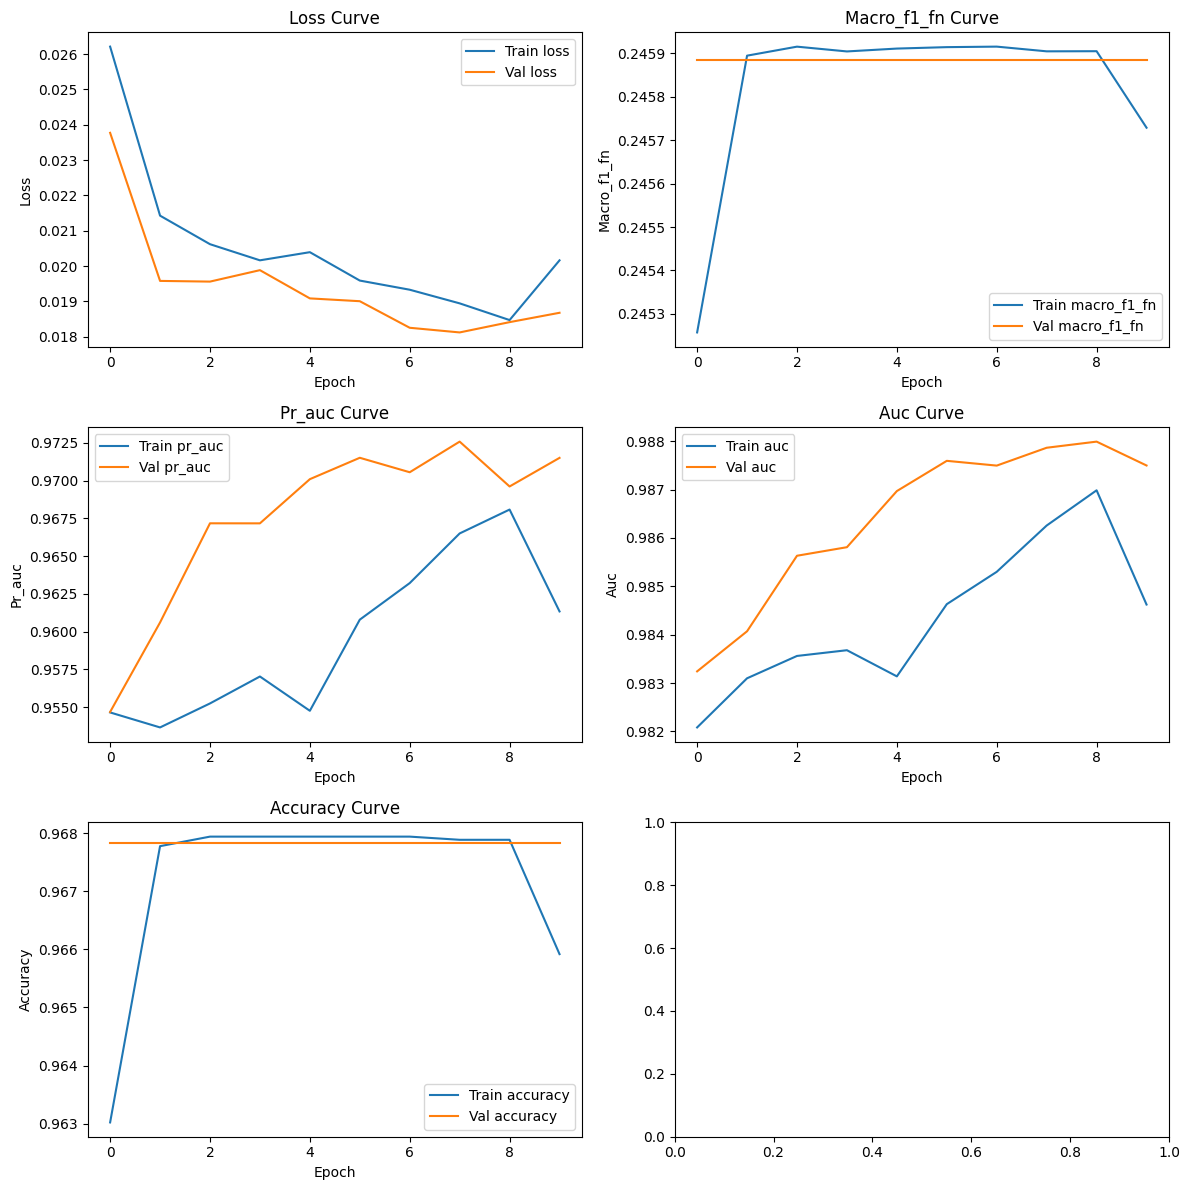

Training curves saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/training_curves_3232.png


<Figure size 640x480 with 0 Axes>

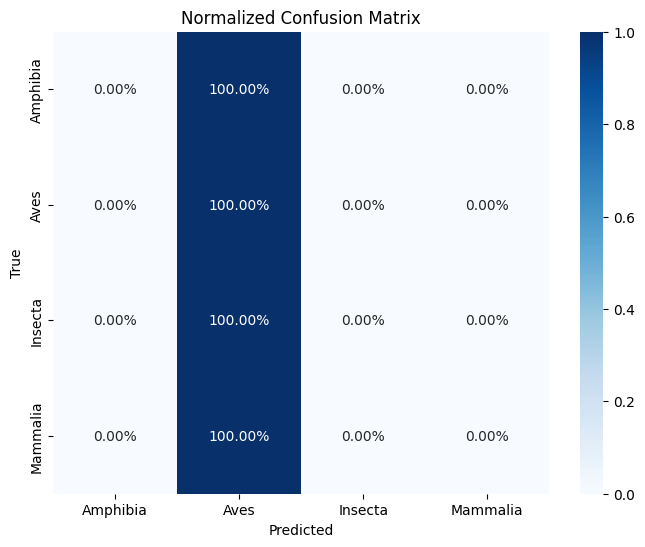

Confusion matrix saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/confusion_matrix_3232.png


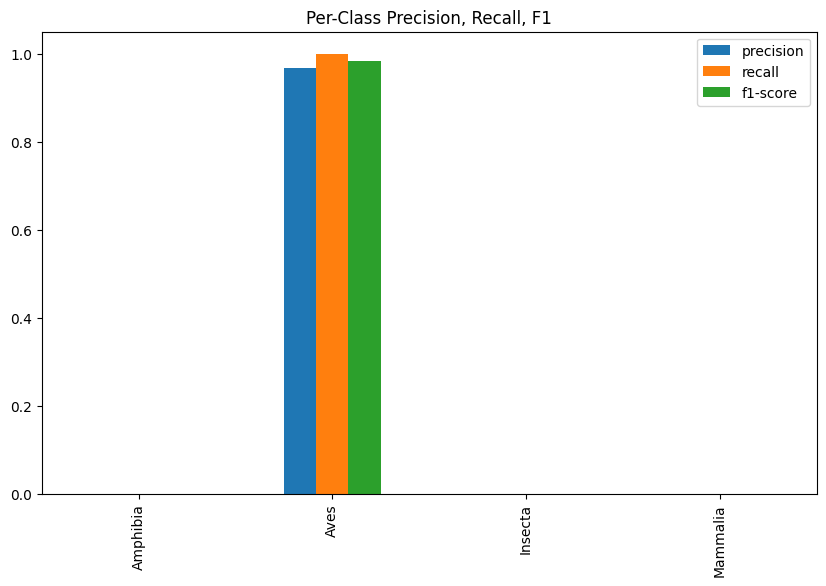

Per-class metrics saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/per_class_metrics_3232.png


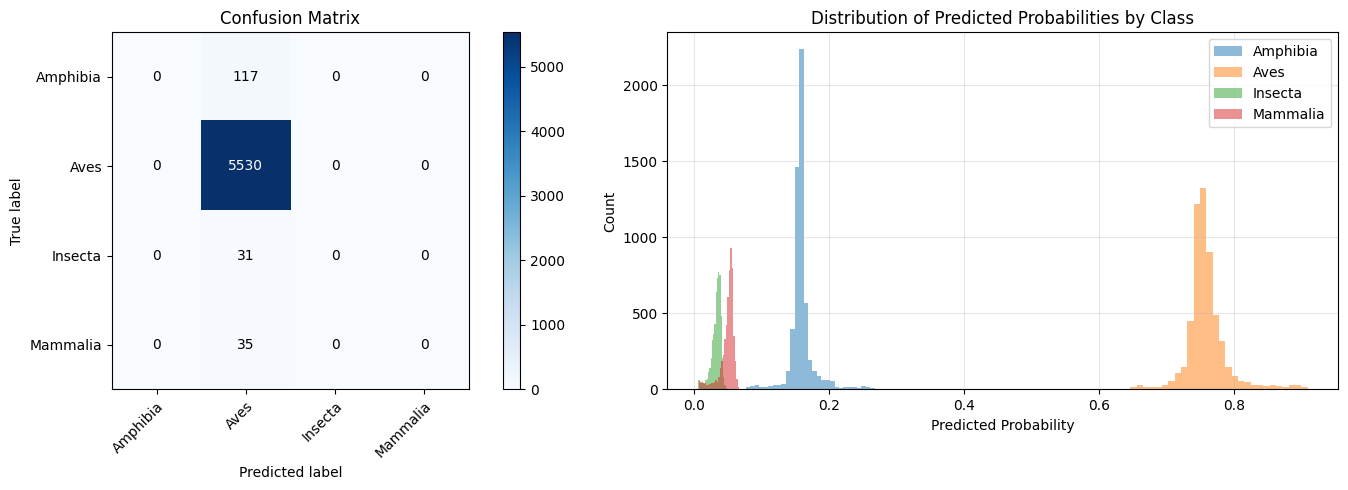

Classification report saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/result_csvs/classification_report_3232.csv

Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.00      0.00      0.00       117
        Aves       0.97      1.00      0.98      5530
     Insecta       0.00      0.00      0.00        31
    Mammalia       0.00      0.00      0.00        35

    accuracy                           0.97      5713
   macro avg       0.24      0.25      0.25      5713
weighted avg       0.94      0.97      0.95      5713



In [15]:
# Run evaluation
test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)
print(f"Test size: {len(test_df)}")

y_true, y_pred = evaluate_on_test(model, cfg, spectrograms, test_df)

plot_training_diagnostics(history, cfg, y_true, y_pred, class_mapping_dict)

# Plot with dictionary
plot_test_evaluation(y_true, y_pred, class_mapping=class_mapping_dict, cfg=cfg)